

```
Author -Aishwarya Pathak

Stock Market Prediction using Numerical and Textual Analysis
Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)
```



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import the Important Libraries**

In [2]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [3]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [4]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("/content/drive/MyDrive/Datasets/stock market prediction using numeric and textual analysis/india-news-headlines.csv",names=columns)

In [5]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [6]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3650961,20220331,Garment industry jittery over'GST hike'
3650962,20220331,AAP MLAs interfering in work: Councillors
3650963,20220331,Schools organise vax camps for kids
3650964,20220331,Madhya Pradesh CM Shivraj Singh Chouhan promis...


In [10]:
# Load the second dataset
columns=['Date','Open','High','Low','Close','Volume']
hisdf = pd.read_csv("/content/drive/MyDrive/Datasets/stock market prediction using numeric and textual analysis/CSVForDate.csv", names=columns)
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,Date,Open,High,Low,Close,NaN
1,1-January-2001,3990.65,4021.83,3937.33,3955.08,NaN
2,2-January-2001,3953.22,4028.57,3929.37,4018.88,NaN
3,3-January-2001,3977.58,4067.66,3977.58,4060.02,NaN
4,4-January-2001,4180.97,4180.97,4109.55,4115.37,NaN
...,...,...,...,...,...,...
5276,17-March-2022,57620.28,58095.84,57518.06,57863.93,NaN
5277,21-March-2022,58030.41,58127.95,57229.08,57292.49,NaN
5278,22-March-2022,57297.57,58052.87,56930.30,57989.30,NaN
5279,23-March-2022,58198.64,58416.56,57568.59,57684.82,NaN


In [11]:
hisdf.drop(0, inplace=True)
hisdf.drop('Volume', axis = 1, inplace=True)

In [12]:
hisdf

,Date,Open,High,Low,Close
1,1-January-2001,3990.65,4021.83,3937.33,3955.08
2,2-January-2001,3953.22,4028.57,3929.37,4018.88
3,3-January-2001,3977.58,4067.66,3977.58,4060.02
4,4-January-2001,4180.97,4180.97,4109.55,4115.37
5,5-January-2001,4116.34,4195.01,4115.35,4183.73
...,...,...,...,...,...
5281,25-March-2022,57801.72,57845.37,57100.24,57362.20
5282,28-March-2022,57472.72,57638.34,56825.09,57593.49
5283,29-March-2022,57814.76,58001.53,57639.35,57943.65
5284,30-March-2022,58362.85,58727.78,58176.00,58683.99


**Common Dataset Exploration**

In [13]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [14]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x))
ndf = ndf.drop_duplicates()
ndf.reset_index(inplace=True,drop=True)

In [15]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [16]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [17]:
len(ndf)

7717

In [19]:
hisdf=hisdf[["Date","Open","High","Low","Close"]]
hisdf.head(-5)

,Date,Open,High,Low,Close
1,1-January-2001,3990.65,4021.83,3937.33,3955.08
2,2-January-2001,3953.22,4028.57,3929.37,4018.88
3,3-January-2001,3977.58,4067.66,3977.58,4060.02
4,4-January-2001,4180.97,4180.97,4109.55,4115.37
5,5-January-2001,4116.34,4195.01,4115.35,4183.73
...,...,...,...,...,...
5276,17-March-2022,57620.28,58095.84,57518.06,57863.93
5277,21-March-2022,58030.41,58127.95,57229.08,57292.49
5278,22-March-2022,57297.57,58052.87,56930.30,57989.30
5279,23-March-2022,58198.64,58416.56,57568.59,57684.82


In [20]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5285 entries, 1 to 5285
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5285 non-null   datetime64[ns]
 1   Open    5285 non-null   object        
 2   High    5285 non-null   object        
 3   Low     5285 non-null   object        
 4   Close   5285 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 206.6+ KB


In [26]:
hisdf['Open'] = hisdf['Open'].astype(np.float32)
hisdf['High'] = hisdf['High'].astype(np.float32)
hisdf['Low'] = hisdf['Low'].astype(np.float32)
hisdf['Close'] = hisdf['Close'].astype(np.float32)

In [27]:
hisdf.describe()

,Open,High,Low,Close
count,5285.000000,5285.000000,5285.000000,5285.000000
mean,20726.791016,20847.935547,20563.427734,20704.462891
std,13861.087891,13913.923828,13769.663086,13842.508789
min,2621.889893,2682.590088,2594.870117,2600.120117
25%,9360.059570,9442.980469,9271.629883,9372.299805
50%,18194.150391,18312.429688,18042.609375,18178.330078
75%,28540.970703,28651.750000,28386.460938,28469.669922
max,62156.480469,62245.429688,61624.648438,61765.589844


In [28]:
# Check for duplicated values
hisdf.isnull().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

In [29]:
len(hisdf)

5285

Text(0, 0.5, 'BSESN')

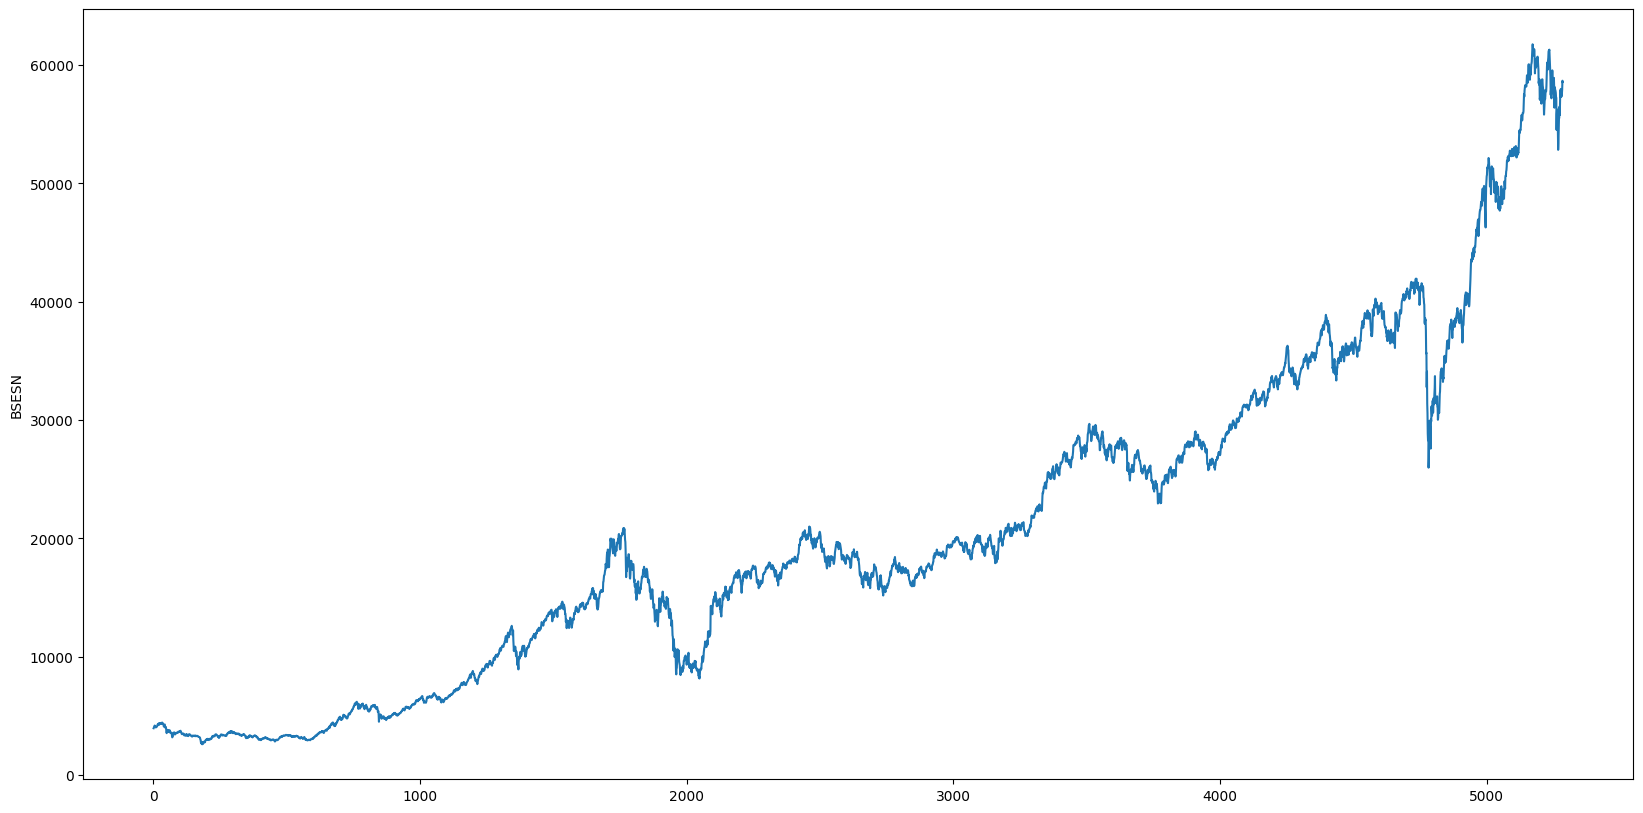

In [30]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

**Remove Unwanted Characters from the News**

In [31]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

# **Historical Analysis**

**Plot the Moving Average**

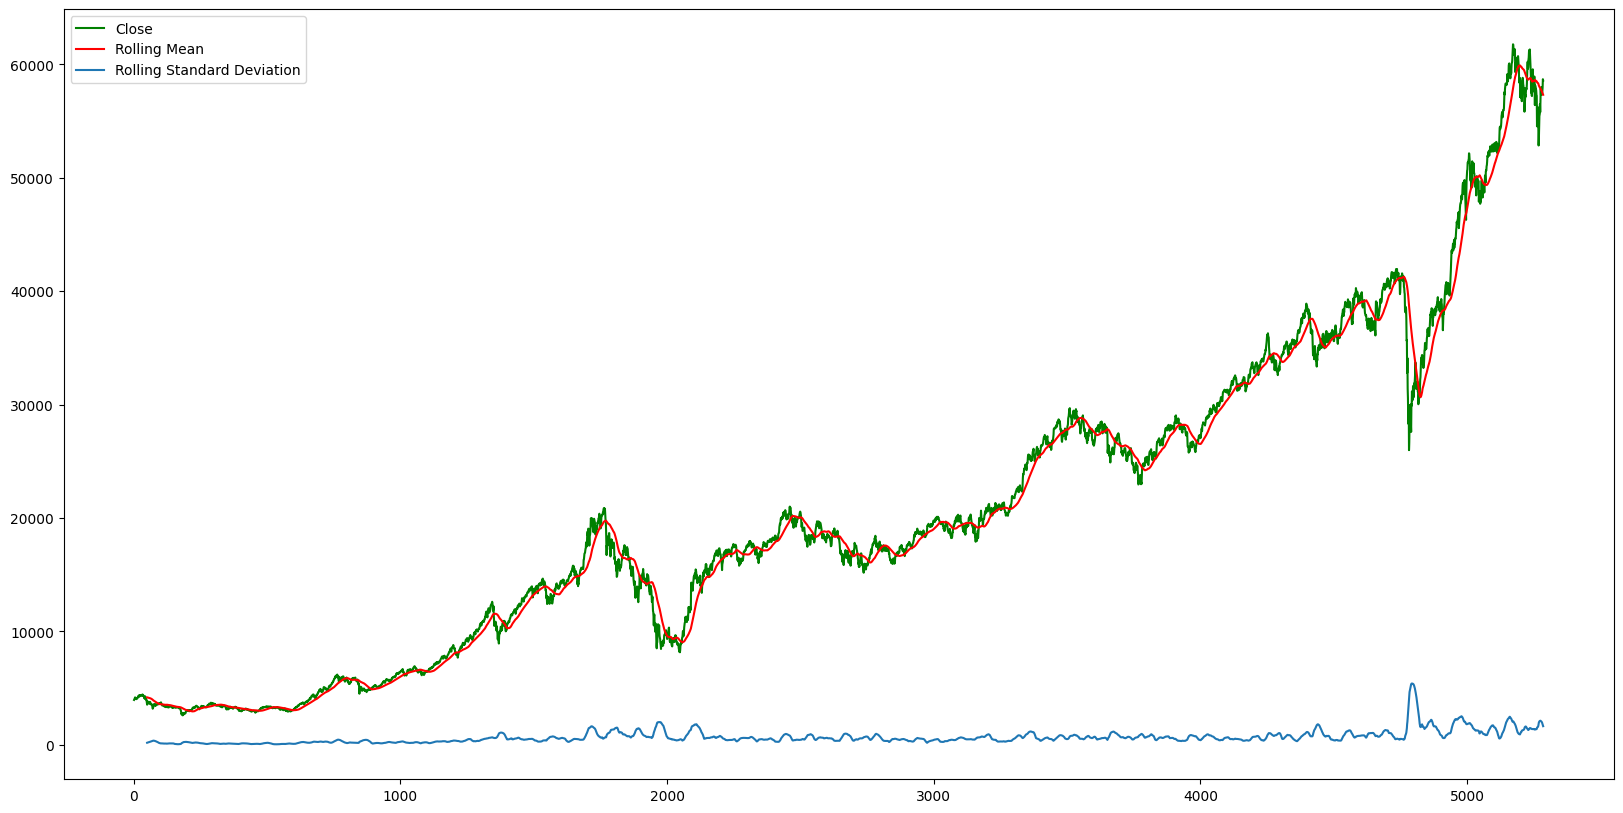

In [32]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

**Plot the Returns**

Text(0.5, 1.0, 'Returns')

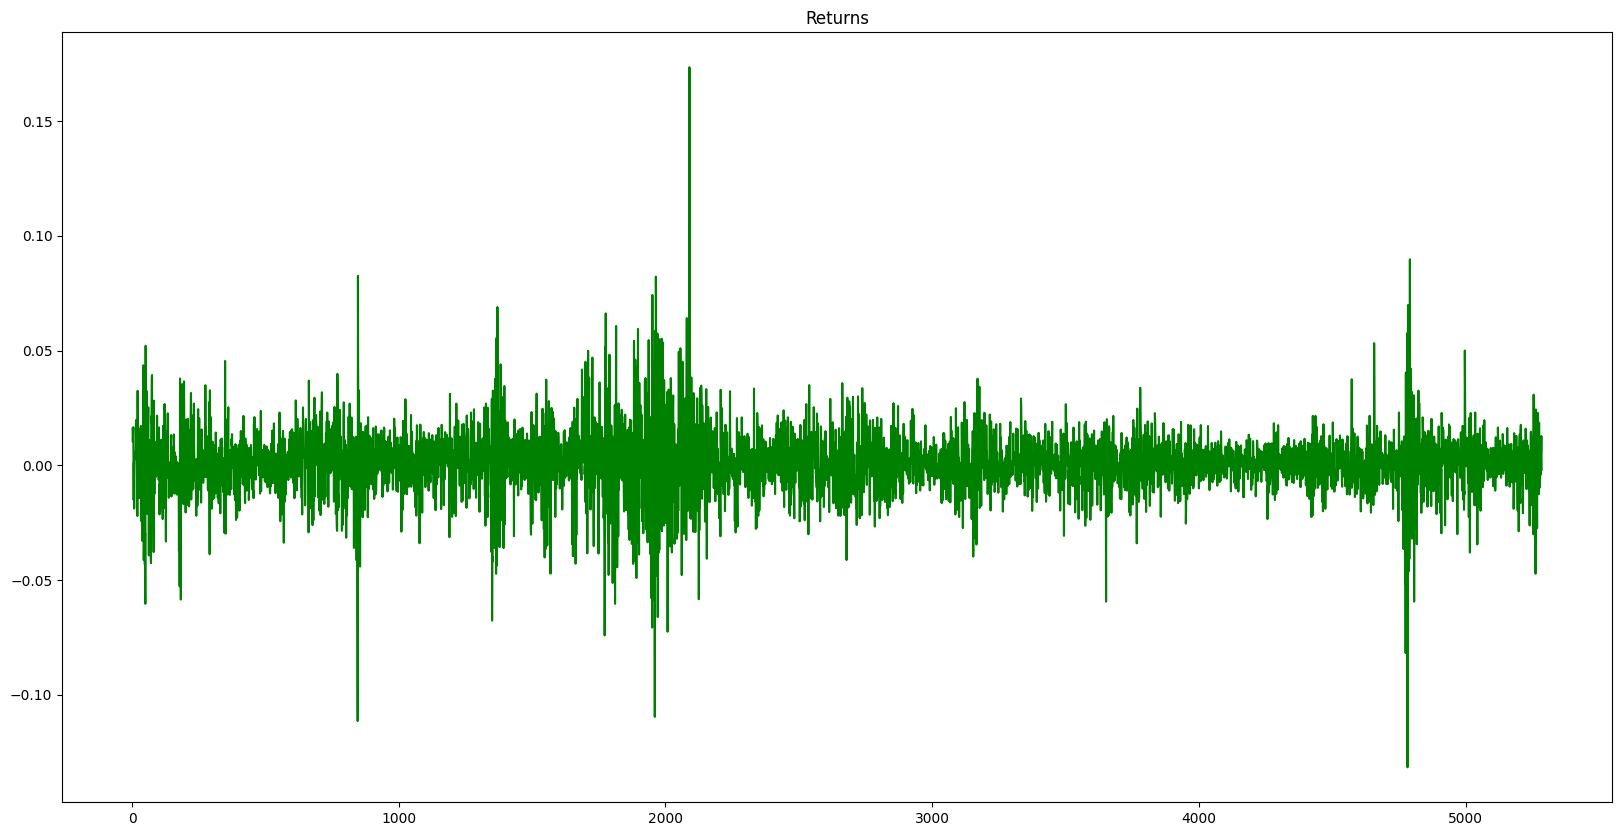

In [33]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [35]:
# Train test split
train = hisdf[:4000]
test = hisdf[4000:]

**Rolling mean and Standard Deviation**

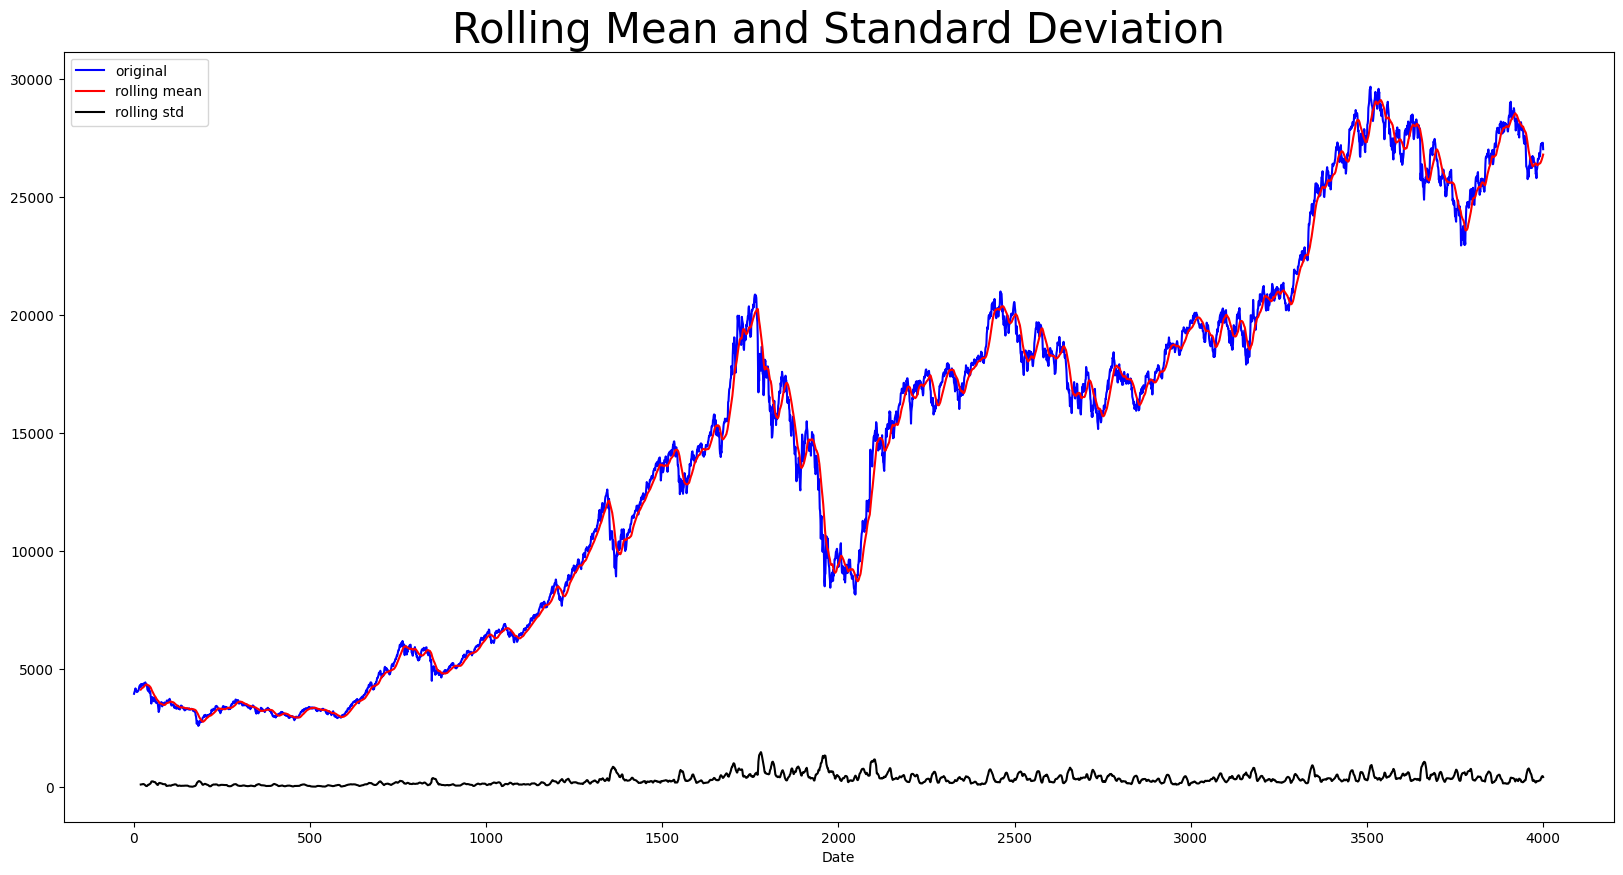

Results of dickey fuller test
ADF Test Statistic : -0.585390512247156
p-value : 0.8742491190777888
#Lags Used : 14
Number of Observations Used : 3985
Weak evidence against null hypothesis, time series is non-stationary 


In [37]:
from statsmodels.tsa.stattools import adfuller

#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)

 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

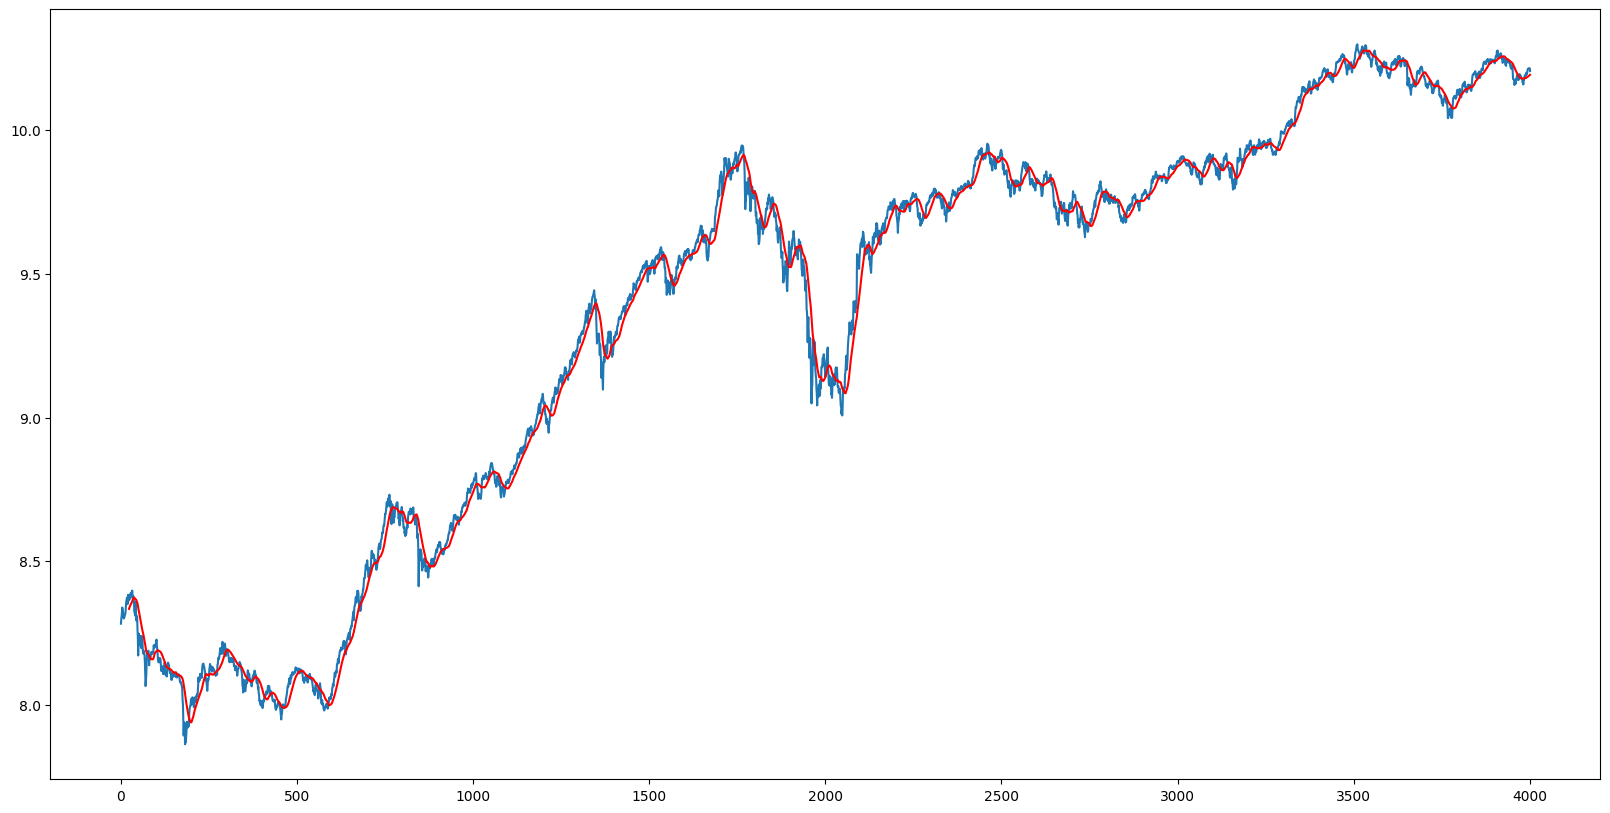

In [38]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(mav, color = 'red')

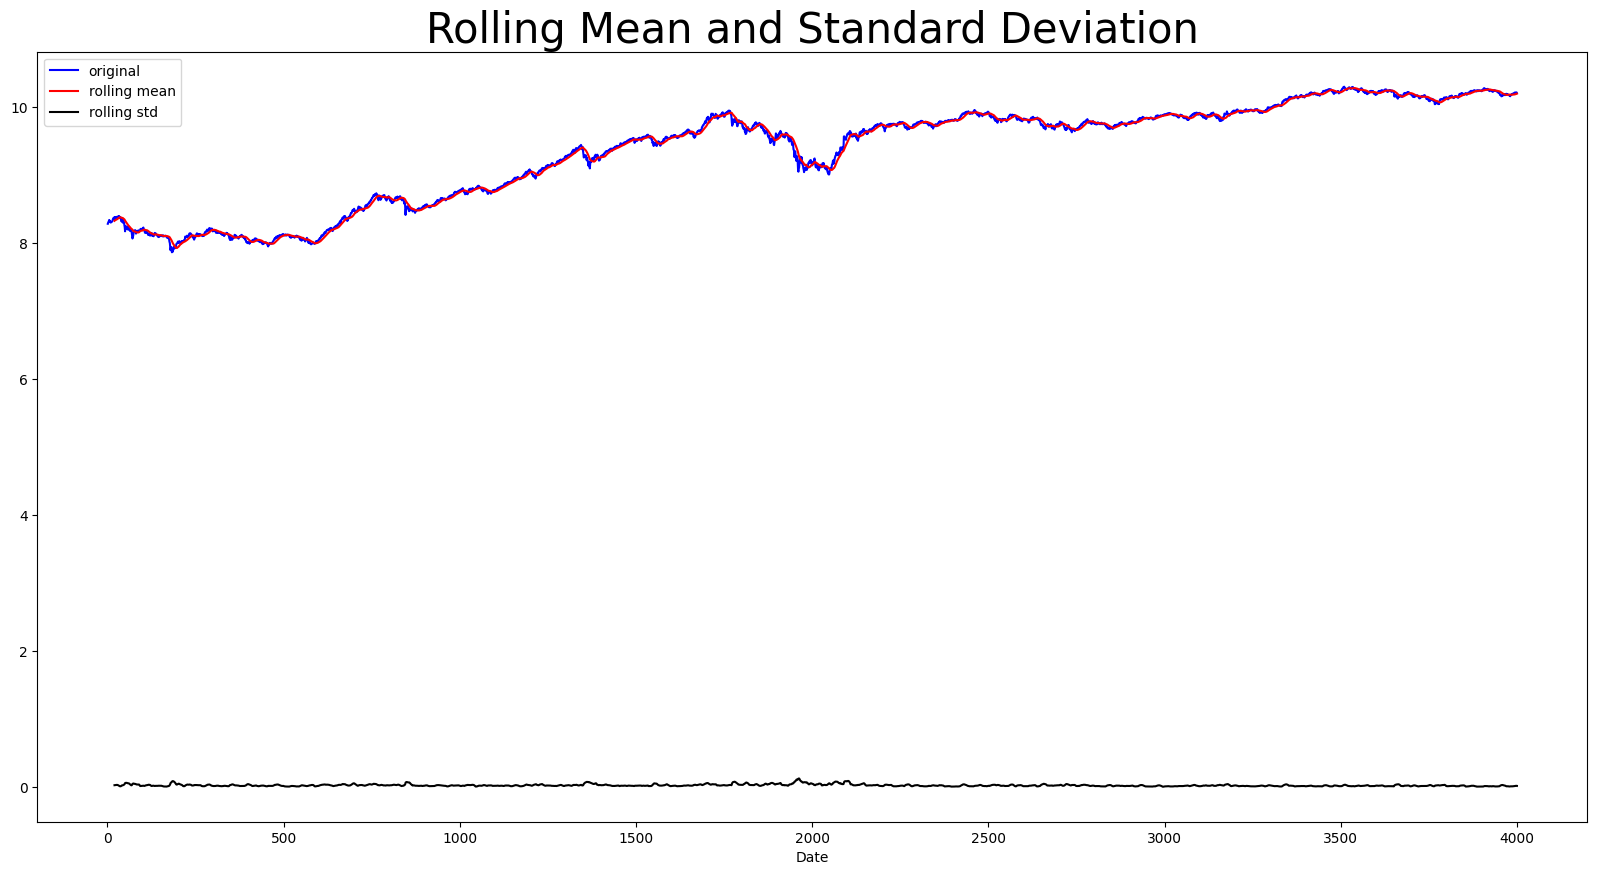

Results of dickey fuller test
ADF Test Statistic : -0.9466250458236973
p-value : 0.772230794203101
#Lags Used : 14
Number of Observations Used : 3985
Weak evidence against null hypothesis, time series is non-stationary 


In [39]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

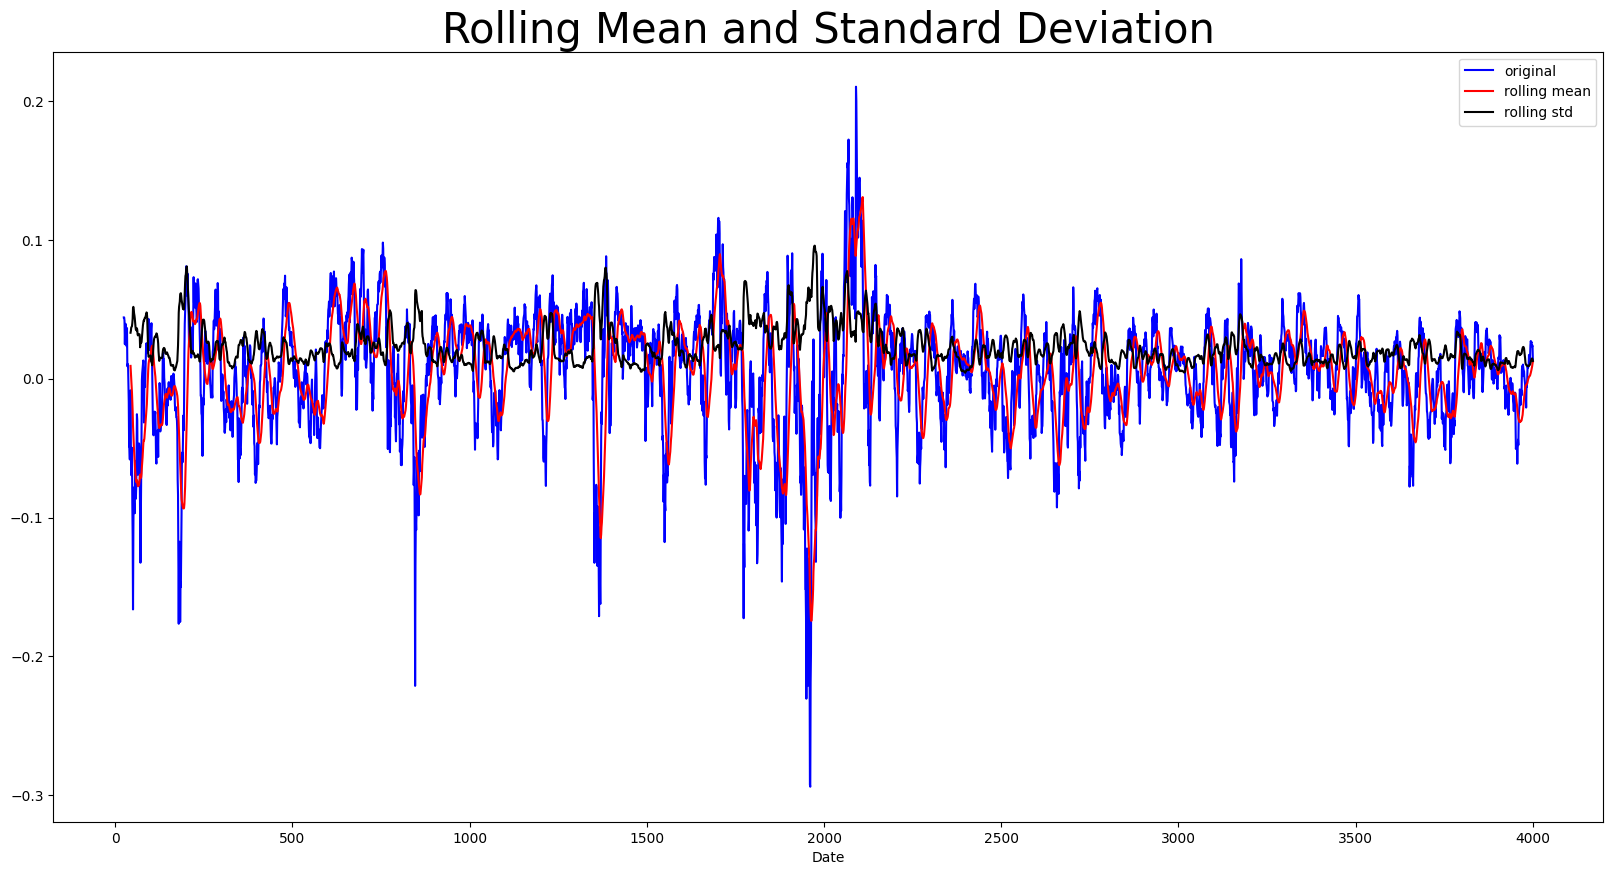

Results of dickey fuller test
ADF Test Statistic : -9.468773057582576
p-value : 4.16050023733693e-16
#Lags Used : 26
Number of Observations Used : 3950
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [40]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [42]:
!pip install pmdarima
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00


In [43]:

model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-22434.977, Time=8.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22408.510, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22430.001, Time=1.80 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22432.458, Time=6.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22406.225, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22437.040, Time=4.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-22438.563, Time=3.79 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-22436.990, Time=9.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22436.418, Time=3.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-22434.955, Time=5.67 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-22436.535, Time=0.90 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 46.216 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0, 0.5, 'Actual Stock Price')

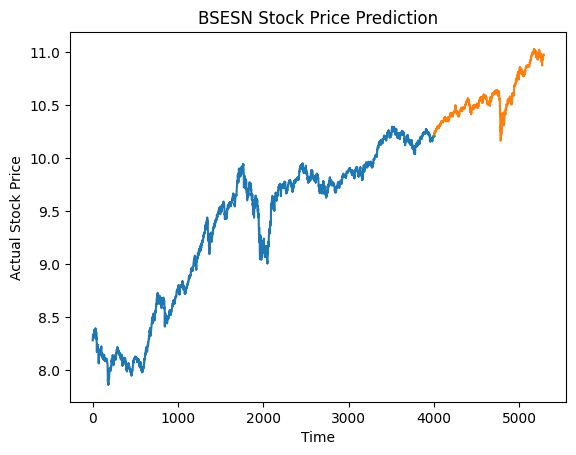

In [44]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

**Textual Analysis**

In [48]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [49]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954


In [51]:
import nltk
nltk.download('vader_lexicon')
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [52]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954,-0.9999,0.156,0.769,0.076


**Merge the Historical and Textual Data**

In [53]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,Sangh Parivar Babri panel up the ante Frontru...,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...
5250,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,Speeding up shortcuts and tackling unruly cus...,0.373221,-0.003922,-1.0000,0.184,0.742,0.074
5251,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
5252,2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086
5253,2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,I will not give in to trends Dossmode The tim...,0.344136,0.039954,-0.9999,0.156,0.769,0.076


**Create Dataset for Model Training**

In [54]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4018.879883,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,4060.020020,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,4115.370117,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,4183.729980,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,4120.430176,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...
5250,57362.199219,0.373221,-0.003922,-1.0000,0.184,0.742,0.074
5251,57593.488281,0.383007,0.058513,-0.9999,0.160,0.737,0.103
5252,57943.648438,0.403627,0.092144,-0.9999,0.159,0.755,0.086
5253,58683.988281,0.344136,0.039954,-0.9999,0.156,0.769,0.076


**Normalize Data**

In [55]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.023980,0.286859,0.513986,0.010401,0.272523,0.809,0.116776
1,0.024675,0.392857,0.439935,0.054503,0.351351,0.735,0.179276
2,0.025610,0.445360,0.445054,0.877194,0.234234,0.792,0.171053
3,0.026766,0.480553,0.678214,0.982299,0.319820,0.694,0.269737
4,0.025696,0.400343,0.302819,0.011051,0.272523,0.813,0.108553


In [56]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.286859,0.513986,0.010401,0.272523,0.809,0.116776
1,0.392857,0.439935,0.054503,0.351351,0.735,0.179276
2,0.445360,0.445054,0.877194,0.234234,0.792,0.171053
3,0.480553,0.678214,0.982299,0.319820,0.694,0.269737
4,0.400343,0.302819,0.011051,0.272523,0.813,0.108553
...,...,...,...,...,...,...
5250,0.373221,0.312834,0.000000,0.414414,0.742,0.121711
5251,0.383007,0.397972,0.000050,0.360360,0.737,0.169408
5252,0.403627,0.443832,0.000050,0.358108,0.755,0.141447
5253,0.344136,0.372664,0.000050,0.351351,0.769,0.125000


In [57]:
Y=df['Close']
Y

0       0.023980
1       0.024675
2       0.025610
3       0.026766
4       0.025696
          ...   
5250    0.925575
5251    0.929484
5252    0.935403
5253    0.947916
5254    0.945964
Name: Close, Length: 5255, dtype: float64

**Split the Dataset into Train & Test Data**

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(4204, 6)

In [59]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
1916,0.396172,0.483268,0.00010,0.486486,0.670,0.187500
2436,0.402079,0.369868,0.00010,0.346847,0.751,0.156250
771,0.450311,0.389798,0.00070,0.376126,0.749,0.138158
2966,0.420315,0.443121,0.00000,0.416667,0.707,0.175987
4843,0.371068,0.416931,0.00015,0.342342,0.731,0.192434
2566,0.414026,0.396880,0.00015,0.319820,0.752,0.174342
220,0.409960,0.437712,0.00105,0.270270,0.783,0.159539
1958,0.404991,0.380673,0.00005,0.466216,0.685,0.177632
2692,0.393296,0.406074,0.00010,0.340090,0.745,0.171053
3763,0.399089,0.417932,0.00005,0.389640,0.720,0.175987


**RandomForestRegressor Model**

In [60]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [61]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.25042592 0.1403287  0.42732488 0.54180906 0.1583913  0.09371902
 0.36471509 0.38630059 0.18059885 0.60647161]
3090    0.283877
138     0.010597
2374    0.267974
4493    0.571996
1855    0.181686
1657    0.232362
1386    0.150621
3251    0.306308
2394    0.287239
5217    0.947254
Name: Close, dtype: float64
Mean Squared error:  0.020078433347301184


**DecisionTreeRegressor Model**

In [62]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [63]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.28845321 0.01759438 0.27501124 0.58175859 0.19207385 0.01065064
 0.69286278 0.23143331 0.24073871 0.43087073]
3090    0.283877
138     0.010597
2374    0.267974
4493    0.571996
1855    0.181686
1657    0.232362
1386    0.150621
3251    0.306308
2394    0.287239
5217    0.947254
Name: Close, dtype: float64
Mean Squared error:  0.036359428698080315


**AdaBoostRegressor Model**

In [64]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [65]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.024874227421517257


**LGBMRegressor Model**

In [66]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1194
[LightGBM] [Info] Number of data points in the train set: 4204, number of used features: 6
[LightGBM] [Info] Start training from score 0.308988


LGBMRegressor()

In [67]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.0196840632441907


**XGBRegressor Model**

In [68]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [69]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.021707163376595097


**Conclusion**

RandomForest = 0.020078433347301184
DecisionTree = 0.036359428698080315
AdaBoost = 0.024874227421517257
LightGBM = 0.0196840632441907
XGBoost = 0.021707163376595097